In [1]:
!pip install wget
!pip install nptdms

In [2]:
%load_ext autoreload
%autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp

# Downloading Raw Files (Download_data.ipynb)

In [3]:
interrogator = "Optasense"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
url = "http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 60
minutes = 5
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}\\results"])
print(filenames)

Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5
['Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5', 'Data/Raw/Ship1/results']


# Loading Raw Data (Data_Cleaning.ipynb)

In [5]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

The concatenated data shape: (47500, 60000)
The first value in "RawDataTime" is 1635902414834000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-03 01:20:14.834000
the time step is equal to =  5000.0 microsecond

sampling rate in Hz =  200.0
channel spacing in m =  2.0419047
number of channels =  47500
number of samples in each channel =  60000
gauge length in m =  51.04762


# Converting Raw Data to AI-Ready Data (Prepare_AI_Ready_Data.ipynb)

In [6]:
distance = [20000, 25000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist = np.concatenate([dist, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate = np.concatenate([str_rate, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}', str_rate)
np.save(f'{folder}/results/time{ship_number}', time)
np.save(f'{folder}/results/dist{ship_number}', dist)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


Number of itterations:  2.0


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


['Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5']


## Downsampling the Data (Dimensionality_Reduction.ipynb)

In [7]:
# Downsample the raw data
str_rate_downsampled = block_reduce(str_rate, block_size=(factor_channels, factor_time), func=np.mean)
# Downsample the distance and time domain data
dist_downsampled = block_reduce(dist, block_size=factor_channels, func=np.mean)
time_downsampled = block_reduce(time, block_size=factor_time, func=np.mean)

# Exploratory Data Analysis

## Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

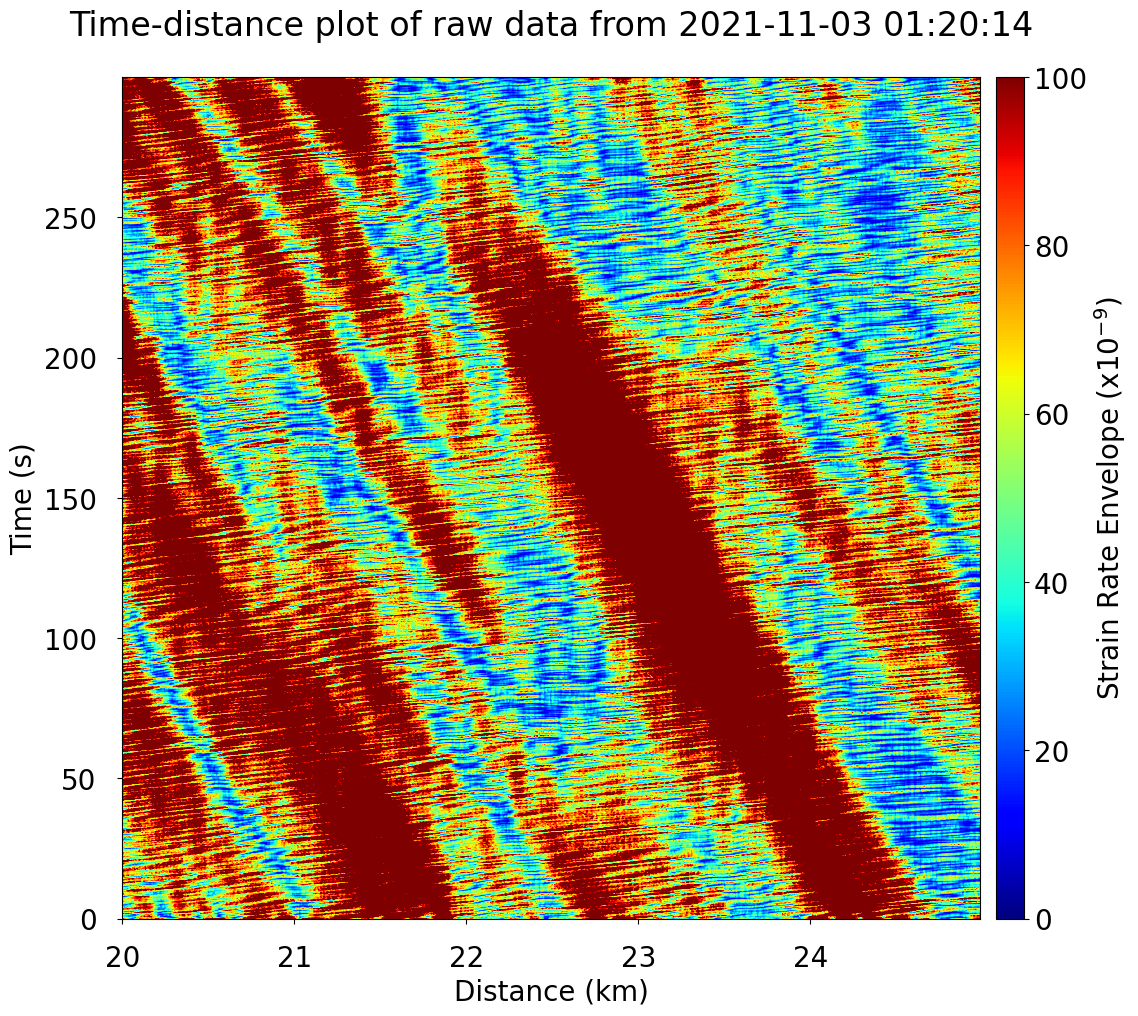

In [8]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_downsampled[0:-2,:], axis=1), time_downsampled, dist_downsampled[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## f-k plot

In [9]:
# Calculating FFT of the raw data
nnx, nns = str_rate.shape
fk_trace = np.fft.fftshift(np.fft.fft2(str_rate))
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=1 / fs))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=channels_chunk[2] * dx))

<function matplotlib.pyplot.show(close=None, block=None)>

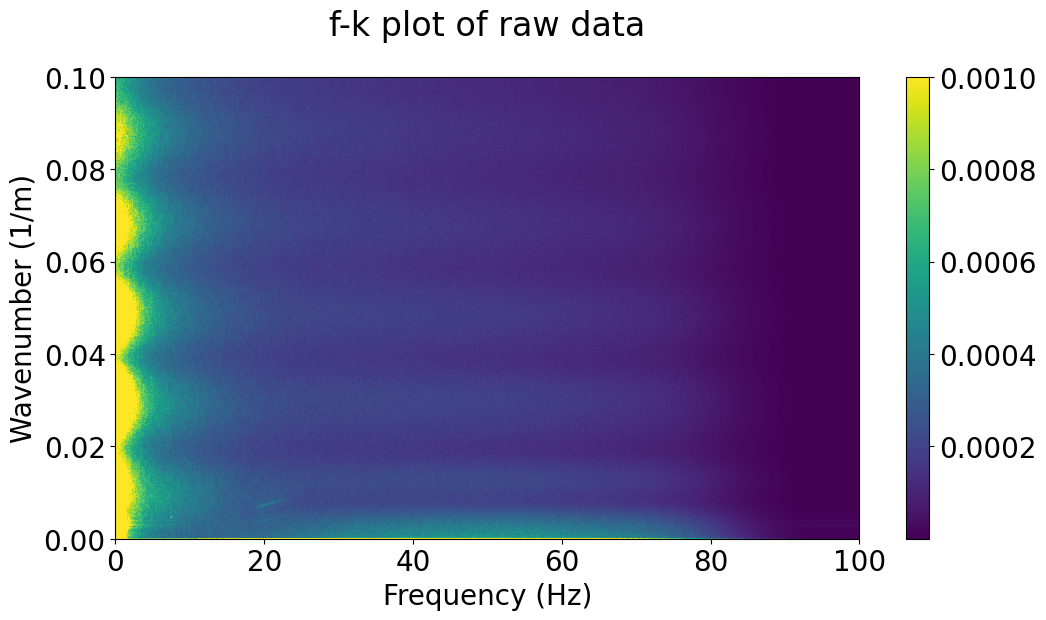

In [10]:
frq_max = 100
frq_min = 0
vmax = 0.001

# Plot the f-k spectrum
plt.figure(figsize=(12, 6))
shw = plt.imshow(np.abs(fk_trace), aspect='auto', extent=[freq[0], freq[-1], knum[0], knum[-1]], origin='lower', vmin=None, vmax=vmax)
plt.colorbar(shw)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Wavenumber (1/m)')
plt.xlim(frq_min, min(frq_max, fs/2))
plt.ylim(0, min(frq_max*0.001, 1/(2*dx)))
plt.title(f'f-k plot of raw data', pad=30)
plt.show

### Histograms and Mean, Max, Min, Variance

In [11]:
#plotting downsampled strain rate - commented out because it takes a very long time to run
"""
plt.figure(figsize = (10,8))
plt.hist(str_rate_downsampled)
plt.title('Strain Rate Histogram')
plt.xlabel('Strain Rate')
plt.ylabel('Frequency')
plt.show()
"""

"\nplt.figure(figsize = (10,8))\nplt.hist(str_rate_downsampled)\nplt.title('Strain Rate Histogram')\nplt.xlabel('Strain Rate')\nplt.ylabel('Frequency')\nplt.show()\n"

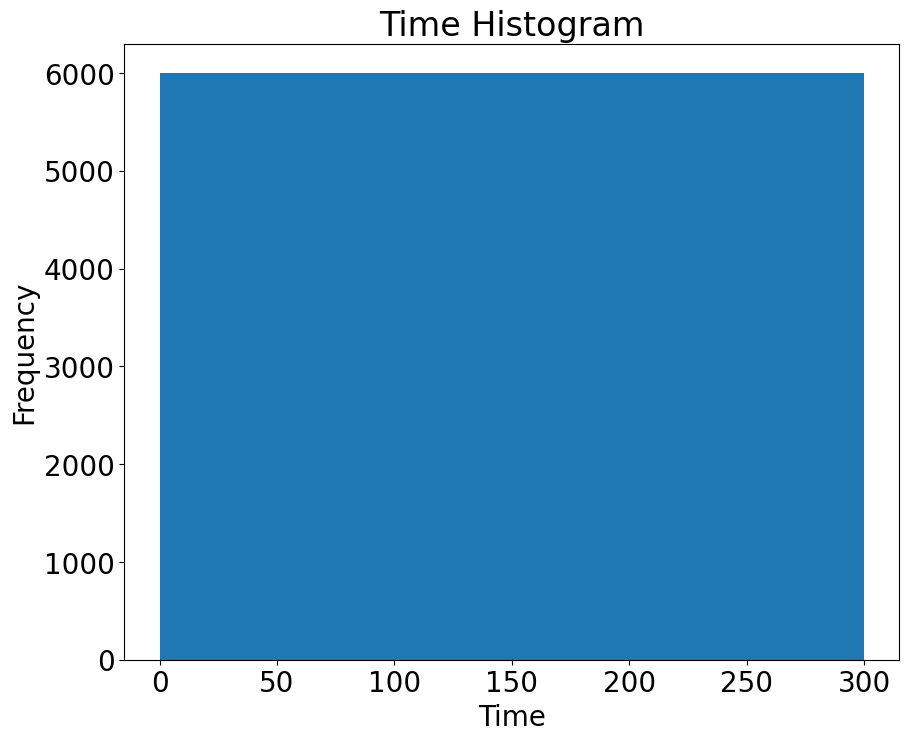

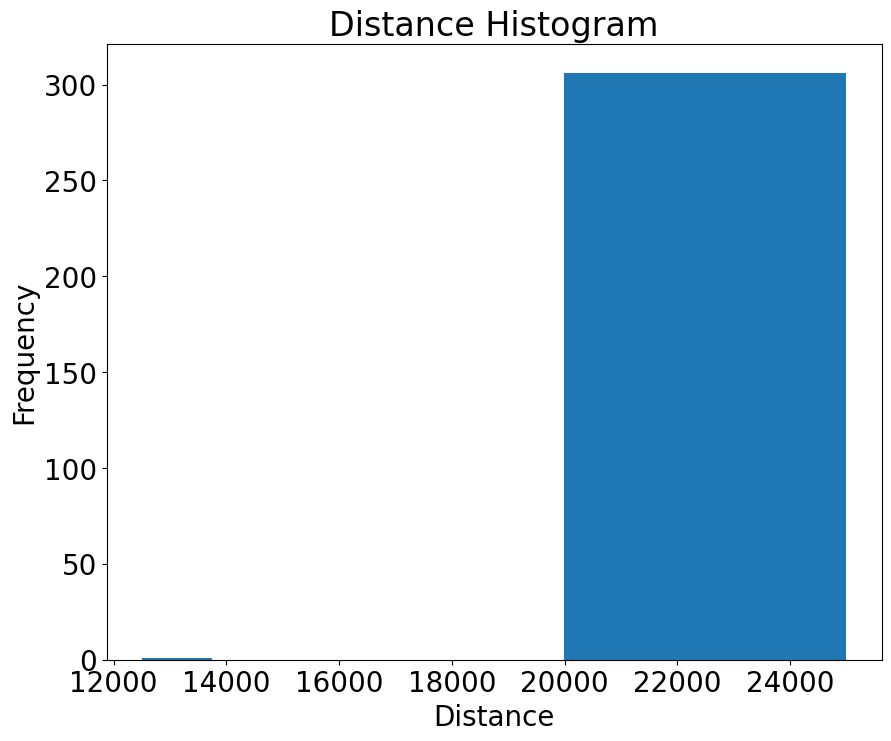

In [12]:
#plotting downsampled time and distance in seperate cell b/c str rate takes long time
plt.figure(figsize = (10,8))
plt.hist(time_downsampled)
plt.title('Time Histogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (10,8))
plt.hist(dist_downsampled)
plt.title('Distance Histogram')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [13]:
#finding stats of raw data
#Looking at mean, min, max, and variance in the raw vs. downsampled data

#loading raw data
str_rate1 = np.load('Data/Raw/Ship1/results/str_rate1.npy')
time1 = np.load('Data/Raw/Ship1/results/time1.npy')
distance1 = np.load('Data/Raw/Ship1/results/dist1.npy')

#finding stats of raw data

#strain rate
print('For the raw strain rate the mean is', np.mean(str_rate1), ', the min is', np.min(str_rate1), ', the max is', np.max(str_rate1), ', and the variance is', np.var(str_rate1))

#time
print('For the raw time the mean is', np.mean(time1), ', the min is', np.min(time1), ', the max is', np.max(time1), ', and the variance is', np.var(time1))

#distance
print('For the raw distance the mean is', np.mean(distance1), ', the min is', np.min(distance1), ', the max is', np.max(distance1), ', and the variance is', np.var(distance1))

#finding stats of the downsampled data
#strain rate
print('For the downsampled strain rate the mean is', np.mean(str_rate_downsampled), ', the min is', np.min(str_rate_downsampled), ', the max is', np.max(str_rate_downsampled), ', and the variance is', np.var(str_rate_downsampled))

#time
print('For the downsampled time the mean is', np.mean(time_downsampled), ', the min is', np.min(time_downsampled), ', the max is', np.max(time_downsampled), ', and the variance is', np.var(time_downsampled))

#distance
print('For the downsampled distance the mean is', np.mean(dist_downsampled), ', the min is', np.min(dist_downsampled), ', the max is', np.max(dist_downsampled), ', and the variance is', np.var(dist_downsampled))

For the raw strain rate the mean is 2.680298645406478e-11 , the min is -4.395981138447465e-06 , the max is 3.2260284412358308e-06 , and the variance is 4.2031595784771446e-15
For the raw time the mean is 149.9975 , the min is 0.0 , the max is 299.995 , and the variance is 7499.999997916667
For the raw distance the mean is 22497.705851078033 , the min is 19998.414513111115 , the max is 24996.997189044952 , and the variance is 2083853.5022452828
For the downsampled strain rate the mean is 2.679204645959359e-11 , the min is -2.197343202950549e-06 , the max is 1.5917017090929387e-06 , and the variance is 4.0537300587259325e-15
For the downsampled time the mean is 149.9975 , the min is 0.0 , the max is 299.995 , and the variance is 7499.999997916667
For the downsampled distance the mean is 22488.52311399596 , the min is 12498.498594522476 , the max is 24993.93433201313 , and the variance is 2161987.7221023007
